# Model Architecture
Project: **Bangla Product Review Sentiment Analysis**

Objectives:
- Data balancing (SMOTE)
- Primary Component Analysis (PCA)
- Explore different model architectures
- Test and evluate

## Data Balancing with SMOTE

In [3]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Read the xlsx file
file_name = "data_with_embeddings.xlsx"
df = pd.read_excel(file_name)

# Convert the string representation of embeddings back to lists and remove extra brackets
df['embedding'] = df['embedding'].apply(lambda x: np.array(eval(x))[0])

# Prepare the input features (X) and target (y)
X = np.stack(df['embedding'].values)
y = np.stack(df['sentiment_numeric'].values)

# Encode the target labels
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the data
smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X_train, y_train)

# You can now use X_sm and y_sm for further processing, e.g., training a classifier


In [4]:
# Check the class distribution before SMOTE
print("Before SMOTE:")
print(pd.Series(y).value_counts())
# Check the class distribution after SMOTE
print("After SMOTE:")
print(pd.Series(y_sm).value_counts())

Before SMOTE:
2    241
0    214
1     73
dtype: int64
After SMOTE:
2    196
1    196
0    196
dtype: int64


## Primary Component Analysis (PCA)

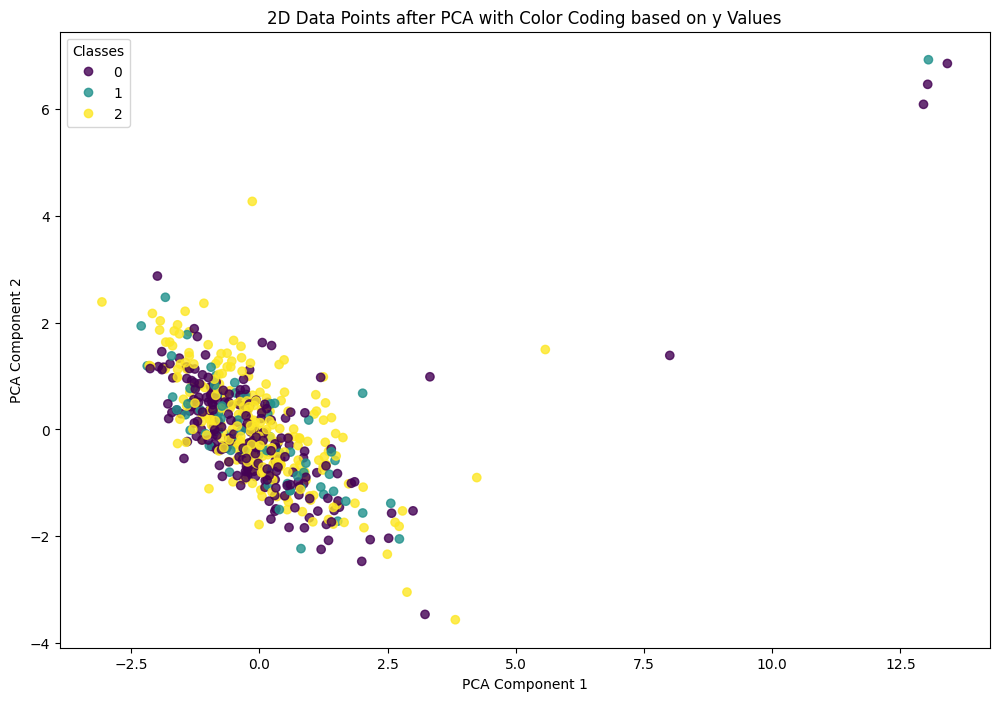

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the 2D data points with color coding based on y values
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.8)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D Data Points after PCA with Color Coding based on y Values")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()


## Decision Tree Classifier

### Default Version

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Train the classifier on the balanced data (X_sm, y_sm)
clf.fit(X_sm, y_sm)

# Make predictions on the test data (X_test)
y_pred = clf.predict(X_test)

# Calculate the test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.4056603773584906


### Hyperparameter Tuning with Grid Search

In [7]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'max_depth': [None, 3, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
}

# Create a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_sm, y_sm)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train the classifier with the best hyperparameters
clf_best = DecisionTreeClassifier(**best_params, random_state=42)
clf_best.fit(X_sm, y_sm)

# Make predictions on the test data (X_test)
y_pred_best = clf_best.predict(X_test)

# Calculate the test accuracy
test_accuracy_best = accuracy_score(y_test, y_pred_best)
print("Test Accuracy (tuned):", test_accuracy_best)


Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy (tuned): 0.4056603773584906


## Random Forest Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the balanced data (X_sm, y_sm)
clf_rf.fit(X_sm, y_sm)

# Make predictions on the test data (X_test)
y_pred_rf = clf_rf.predict(X_test)

# Calculate the test accuracy
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Test Accuracy (Random Forest):", test_accuracy_rf)


Test Accuracy (Random Forest): 0.4811320754716981


## LSTM Model

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding

# Preparing the data
num_classes = 3
X_train = np.array(X_sm).reshape(-1, 1, 768)
y_train = tf.keras.utils.to_categorical(y_sm, num_classes)

X_test = np.array(X_test).reshape(-1, 1, 768)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Building the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(1, 768), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluating the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/30
19/19 [==============================] - 6s 47ms/step - loss: 1.0985 - accuracy: 0.3248 - val_loss: 1.0773 - val_accuracy: 0.4528
Epoch 2/30
19/19 [==============================] - 0s 8ms/step - loss: 1.0879 - accuracy: 0.3759 - val_loss: 1.1469 - val_accuracy: 0.1509
Epoch 3/30
19/19 [==============================] - 0s 7ms/step - loss: 1.0688 - accuracy: 0.4099 - val_loss: 1.0779 - val_accuracy: 0.4245
Epoch 4/30
19/19 [==============================] - 0s 9ms/step - loss: 1.0475 - accuracy: 0.4626 - val_loss: 1.1658 - val_accuracy: 0.2925
Epoch 5/30
19/19 [==============================] - 0s 8ms/step - loss: 1.0219 - accuracy: 0.4728 - val_loss: 1.0777 - val_accuracy: 0.4906
Epoch 6/30
19/19 [==============================] - 0s 9ms/step - loss: 0.9799 - accuracy: 0.5102 - val_loss: 1.0942 - val_accuracy: 0.4811
Epoch 7/30
19/19 [==============================] - 0s 7ms/step - loss: 0.9529 - accuracy: 0.5578 - val_loss: 1.2167 - val_accuracy: 0.3585
Epoch 8/30
19/19 [=

## Bidirectional LSTM

In [28]:
from tensorflow.keras.layers import Bidirectional

# Building the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128), input_shape=(1, 768)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluating the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/30
19/19 [==============================] - 5s 48ms/step - loss: 1.1162 - accuracy: 0.3554 - val_loss: 1.0492 - val_accuracy: 0.4245
Epoch 2/30
19/19 [==============================] - 0s 7ms/step - loss: 1.0991 - accuracy: 0.3248 - val_loss: 1.0905 - val_accuracy: 0.3774
Epoch 3/30
19/19 [==============================] - 0s 8ms/step - loss: 1.0750 - accuracy: 0.4388 - val_loss: 1.1494 - val_accuracy: 0.2453
Epoch 4/30
19/19 [==============================] - 0s 8ms/step - loss: 1.0624 - accuracy: 0.4286 - val_loss: 1.0477 - val_accuracy: 0.4623
Epoch 5/30
19/19 [==============================] - 0s 8ms/step - loss: 1.0233 - accuracy: 0.4881 - val_loss: 1.1490 - val_accuracy: 0.3396
Epoch 6/30
19/19 [==============================] - 0s 7ms/step - loss: 1.0006 - accuracy: 0.5153 - val_loss: 1.1248 - val_accuracy: 0.3962
Epoch 7/30
19/19 [==============================] - 0s 8ms/step - loss: 0.9589 - accuracy: 0.5408 - val_loss: 1.0483 - val_accuracy: 0.5000
Epoch 8/30
19/19 [=

## 1D Convolutional Neural Network (CNN)

In [30]:
from tensorflow.keras.layers import GlobalMaxPooling1D

# Building the 1D CNN model
model = Sequential()
model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(1, 768), padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluating the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/30
19/19 [==============================] - 6s 26ms/step - loss: 1.1035 - accuracy: 0.3639 - val_loss: 1.0934 - val_accuracy: 0.3774
Epoch 2/30
19/19 [==============================] - 0s 6ms/step - loss: 1.0796 - accuracy: 0.3963 - val_loss: 1.1789 - val_accuracy: 0.1698
Epoch 3/30
19/19 [==============================] - 0s 6ms/step - loss: 1.0647 - accuracy: 0.4575 - val_loss: 1.1587 - val_accuracy: 0.1887
Epoch 4/30
19/19 [==============================] - 0s 6ms/step - loss: 1.0454 - accuracy: 0.4745 - val_loss: 1.0472 - val_accuracy: 0.4245
Epoch 5/30
19/19 [==============================] - 0s 6ms/step - loss: 1.0350 - accuracy: 0.4609 - val_loss: 1.0792 - val_accuracy: 0.3962
Epoch 6/30
19/19 [==============================] - 0s 6ms/step - loss: 1.0132 - accuracy: 0.4847 - val_loss: 1.1352 - val_accuracy: 0.3396
Epoch 7/30
19/19 [==============================] - 0s 7ms/step - loss: 1.0011 - accuracy: 0.5000 - val_loss: 1.1586 - val_accuracy: 0.3019
Epoch 8/30
19/19 [=

## Transformer model

In [29]:
from tensorflow.keras.layers import MultiHeadAttention

# Transformer block
def transformer_block(embed_dim, num_heads, ff_dim, rate=0.1):
    inputs = tf.keras.Input(shape=(None, embed_dim))
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attn_output = Dropout(rate)(attn_output)
    out1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(rate)(ffn_output)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Building the Transformer model
embed_dim = 768
num_heads = 2
ff_dim = 512

inputs = tf.keras.Input(shape=(1, 768))
x = transformer_block(embed_dim, num_heads, ff_dim)(inputs)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluating the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/30
19/19 [==============================] - 5s 23ms/step - loss: 1.5742 - accuracy: 0.3078 - val_loss: 1.0804 - val_accuracy: 0.4245
Epoch 2/30
19/19 [==============================] - 0s 10ms/step - loss: 1.1021 - accuracy: 0.3061 - val_loss: 1.0993 - val_accuracy: 0.4057
Epoch 3/30
19/19 [==============================] - 0s 9ms/step - loss: 1.0982 - accuracy: 0.3333 - val_loss: 1.1000 - val_accuracy: 0.1509
Epoch 4/30
19/19 [==============================] - 0s 9ms/step - loss: 1.0979 - accuracy: 0.3333 - val_loss: 1.1003 - val_accuracy: 0.1509
Epoch 5/30
19/19 [==============================] - 0s 9ms/step - loss: 1.0975 - accuracy: 0.3724 - val_loss: 1.1102 - val_accuracy: 0.4245
Epoch 6/30
19/19 [==============================] - 0s 10ms/step - loss: 1.0992 - accuracy: 0.3435 - val_loss: 1.0998 - val_accuracy: 0.1509
Epoch 7/30
19/19 [==============================] - 0s 10ms/step - loss: 1.0934 - accuracy: 0.3350 - val_loss: 1.1196 - val_accuracy: 0.2170
Epoch 8/30
19/19

## KNN

In [33]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# Euclidean distance
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

# Cosine similarity to distance
def cosine_distance(x, y):
    similarity = cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))
    return 1 - similarity

# Train and evaluate KNN model
def train_and_evaluate_knn(k, distance_function, X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier(n_neighbors=k, metric=distance_function)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Reshape the input data
X_train_reshaped = X_sm.reshape(-1, 768)
X_test_reshaped = X_test.reshape(-1, 768)

# Convert one-hot encoded labels to integer class labels
y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)

# Find the best k and distance measure
best_k = 1
best_distance_function = euclidean_distance
best_accuracy = 0

for k in range(1, 11):
    for distance_function in [euclidean_distance, cosine_distance]:
        accuracy = train_and_evaluate_knn(k, distance_function, X_train_reshaped, y_train_int, X_test_reshaped, y_test_int)
        print(f'k: {k}, distance_function: {distance_function.__name__}, accuracy: {accuracy}')
        
        if accuracy > best_accuracy:
            best_k = k
            best_distance_function = distance_function
            best_accuracy = accuracy

print(f'Best k: {best_k}, best distance function: {best_distance_function.__name__}, best accuracy: {best_accuracy}')


k: 1, distance_function: euclidean_distance, accuracy: 0.3867924528301887
k: 1, distance_function: cosine_distance, accuracy: 0.39622641509433965
k: 2, distance_function: euclidean_distance, accuracy: 0.39622641509433965
k: 2, distance_function: cosine_distance, accuracy: 0.41509433962264153
k: 3, distance_function: euclidean_distance, accuracy: 0.3490566037735849
k: 3, distance_function: cosine_distance, accuracy: 0.3584905660377358
k: 4, distance_function: euclidean_distance, accuracy: 0.42452830188679247
k: 4, distance_function: cosine_distance, accuracy: 0.37735849056603776
k: 5, distance_function: euclidean_distance, accuracy: 0.36792452830188677
k: 5, distance_function: cosine_distance, accuracy: 0.3584905660377358
k: 6, distance_function: euclidean_distance, accuracy: 0.3867924528301887
k: 6, distance_function: cosine_distance, accuracy: 0.36792452830188677
k: 7, distance_function: euclidean_distance, accuracy: 0.32075471698113206
k: 7, distance_function: cosine_distance, accura